In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jellyfish
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot
from scipy.sparse import vstack

from matchers import metrics, utils, dataset

In [3]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [4]:
# Only need to run this once
# It we split the data into train/test and will persist the data on disk
# dataset.load_split_init(test_size=0.1)

In [5]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, all_candidates_train = train
input_names_test, weighted_relevant_names_test, all_candidates_test = test

all_candidates = np.concatenate((all_candidates_train, all_candidates_test))

### Model

In [6]:
def calc_similarity_to(name, alg='levenshtein'):
    def calc_similarity(row):
        cand_name = row[0]
        similarity = 0
        if alg == 'levenshtein':
            dist = jellyfish.levenshtein_distance(name, cand_name)
            similarity = 1 - (dist / (max(len(name), len(cand_name)) - 2))
        elif alg == 'jaro_winkler':
            similarity = jellyfish.jaro_winkler_similarity(name.strip('<>'), cand_name.strip('<>'))
        return similarity
    return calc_similarity

#### Similarity Function

In [7]:
def get_similars(name, k=10, alg='levenshtein', demo_mode=False):
    if demo_mode:
        name = utils.add_padding(name)
    scores = np.apply_along_axis(calc_similarity_to(name, alg), 1, all_candidates[:,None])
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [utils.remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [8]:
# get_similars('schumacher', 10, 'jaro_winkler', True)
get_similars('bostelman', 10, 'levenshtein', True)

[('bostelman', 1.0),
 ('bostelmann', 0.9),
 ('bostleman', 0.7777777777777778),
 ('vosselman', 0.7777777777777778),
 ('osterman', 0.7777777777777778),
 ('bokelman', 0.7777777777777778),
 ('bockelman', 0.7777777777777778),
 ('bushelman', 0.7777777777777778),
 ('fosselmann', 0.7),
 ('klosterman', 0.7)]

## Generate levenshtein scores for all test names

In [9]:
k = 100 # Number of candidates to consider
lev_name_candidates = list(map(lambda x: get_similars(x, k=k, alg='levenshtein'), tqdm(input_names_test)))

100%|██████████| 2444/2444 [03:20<00:00, 12.16it/s]


In [10]:
len(lev_name_candidates)

2444

#### Ugh - how can I specify [[[str,float64]]] without taking apart and re-assembling the array?

In [12]:
names = np.array(list(list(cell[0] for cell in row) for row in lev_name_candidates), dtype='O')
scores = np.array(list(list(cell[1] for cell in row) for row in lev_name_candidates), dtype='f8')
lev_candidates = np.dstack((names, scores))

### Evaluation

#### Precision@0.8

In [13]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, lev_candidates, 0.8)

0.5752773261552264

#### Recall@0.8

In [14]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, lev_candidates, 0.8)

0.874764347319197

#### Precision-Recall Curve

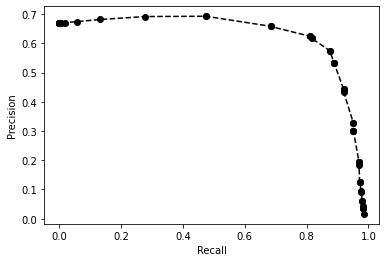

In [15]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, lev_candidates, min_threshold)

## Generate jaro-winkler scores for all test names

In [ ]:
k = 100 # Number of candidates to consider
jw_name_candidates = list(map(lambda x: get_similars(x, k=k, alg='jaro_winkler'), tqdm(input_names_test)))

 69%|██████▉   | 1696/2444 [02:13<00:58, 12.75it/s]

In [ ]:
len(jw_name_candidates)

In [ ]:
names = np.array(list(list(cell[0] for cell in row) for row in jw_name_candidates), dtype='O')
scores = np.array(list(list(cell[1] for cell in row) for row in jw_name_candidates), dtype='f8')
jw_candidates = np.dstack((names, scores))

#### Precision@0.92

In [ ]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, jw_candidates, 0.92)

#### Recall@0.92

In [ ]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, jw_candidates, 0.92)

#### Precision-Recall Curve

In [ ]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, jw_candidates, min_threshold)

## Test

In [ ]:
input_names_test[251]

In [ ]:
weighted_relevant_names_test[251]

In [ ]:
lev_candidates[251,:5]

In [ ]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], lev_candidates[251], 0.85)

In [ ]:
metrics.recall_at_threshold(weighted_relevant_names_test[251], lev_candidates[251], 0.75)